# Preparing enviroment

In [250]:
!rm *.h5

In [1]:
import warnings
warnings.filterwarnings('ignore')
!pip -q install opendatasets
!pip -q install pandas
!pip -q install darknet
!pip -q install numba

In [ ]:
import opendatasets as od
import pandas

od.download(
    "https://mm.cs.uec.ac.jp/uecfoodpix/UECFOODPIXCOMPLETE.tar")

In [ ]:
! tar xf /kaggle/working/UECFOODPIXCOMPLETE.tar
! rm /kaggle/working/UECFOODPIXCOMPLETE.tar

# importes

In [4]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pydot
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
from tensorflow import keras
from keras import layers
from os import path
import imageio



import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Directories

In [5]:
DRIVE_FOLDER = "/kaggle/working/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE"
SUBSET_FOLDER = ""

TRAIN_IMAGE_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/train/img")
TRAIN_MASK_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/train/mask")

TEST_IMAGE_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/test/img")
TEST_MASK_DIR = pathlib.Path(DRIVE_FOLDER + SUBSET_FOLDER + "/test/mask")

# Settings

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
BUFFER_SIZE = 500

CLASSES = 103

NUM_TRAIN_IMAGES = 6300
NUM_VAL_IMAGES = 2700

# Loading data

In [7]:
train_images = sorted(glob(str(TRAIN_IMAGE_DIR/'*.jpg')))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(str(TRAIN_MASK_DIR/'*.png')))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(str(TRAIN_IMAGE_DIR/'*.jpg')))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(str(TRAIN_MASK_DIR/'*.png')))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]

test_images = sorted(glob(str(TEST_IMAGE_DIR/'*.jpg')))
test_masks = sorted(glob(str(TEST_MASK_DIR/'*.png')))

print(len(train_images))
print(len(val_images))
print(len(test_images))

6300
2700
1000


# Visualize data

(Array([  0,  83, 255], dtype=uint8), array([459397,  59003, 172800]))
(Array([  0,   6,  36, 255], dtype=uint8), array([706389,  69726,  33885, 270000]))
(Array([  0,   6, 101, 102, 255], dtype=uint8), array([174353,  51111,   3687,   1249,  76800]))


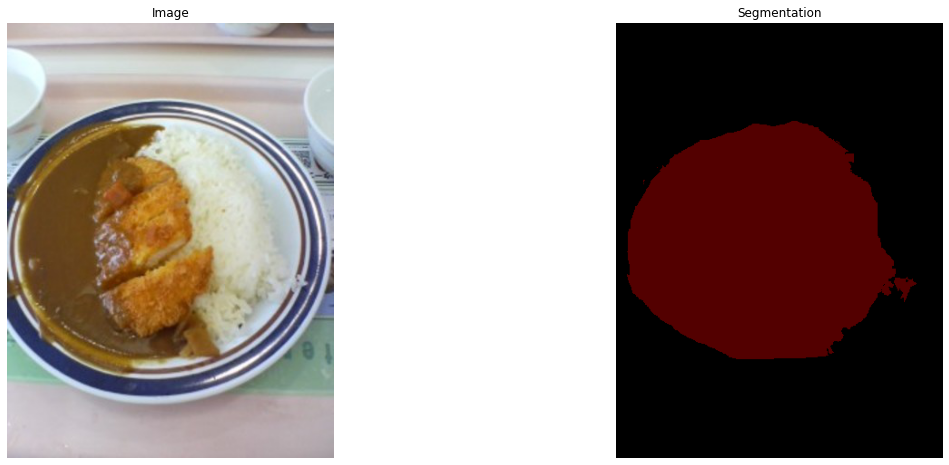

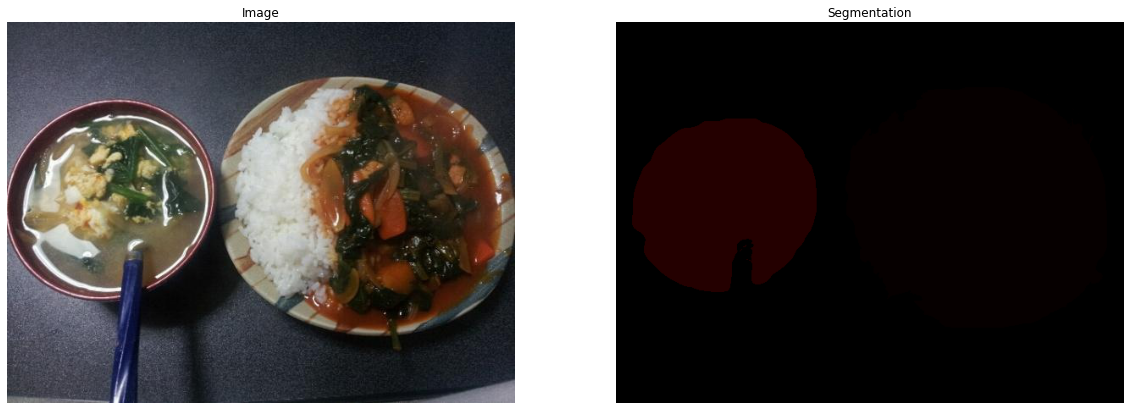

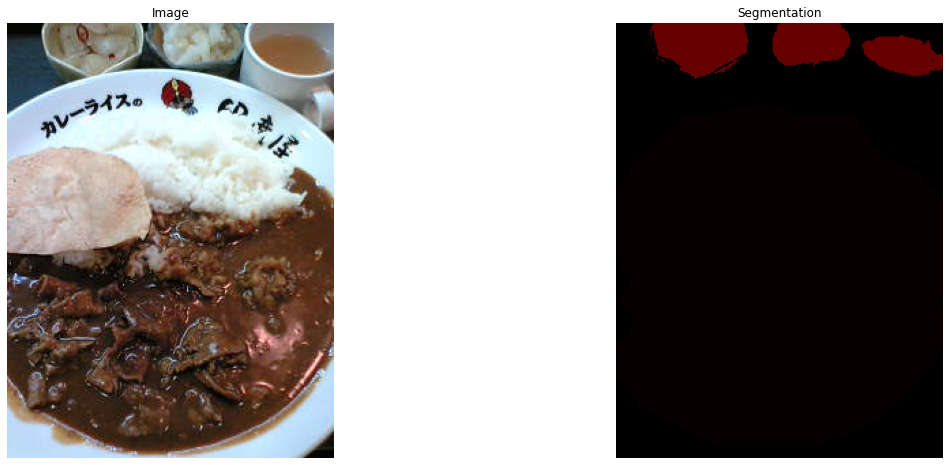

In [9]:
import random
number_of_samples = len(train_images)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)

    img = imageio.imread(train_images[N])
    mask = imageio.imread(train_masks[N])
    
    fig, arr = plt.subplots(1, 2, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")
    print(np.unique(mask, return_counts=True))

# Generating Dataset

In [8]:
def read_image(image_path, mask_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), method='nearest')
    
    return image, mask

In [9]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset

In [11]:
train_dataset = data_generator(train_images, train_masks, BUFFER_SIZE, BATCH_SIZE)
validation_dataset = data_generator(val_images, val_masks, BUFFER_SIZE, BATCH_SIZE)
test_dataset = data_generator(test_images, test_masks, BUFFER_SIZE, BATCH_SIZE)

print(train_dataset)
print(validation_dataset)
print(test_dataset)

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>


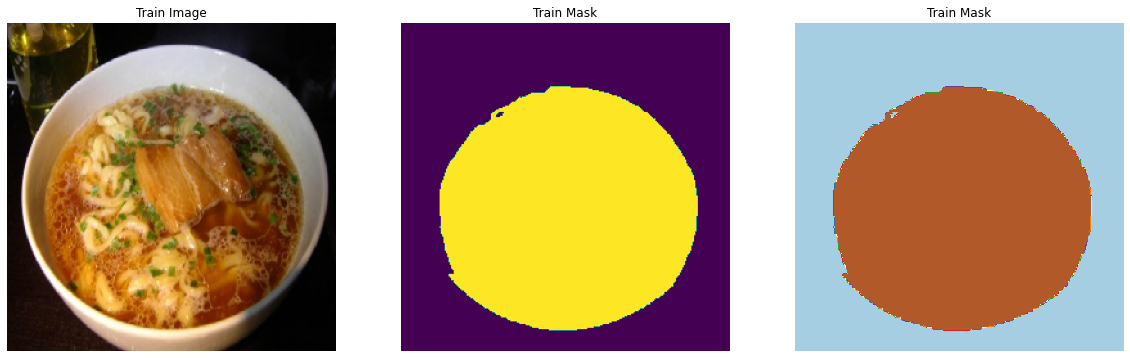

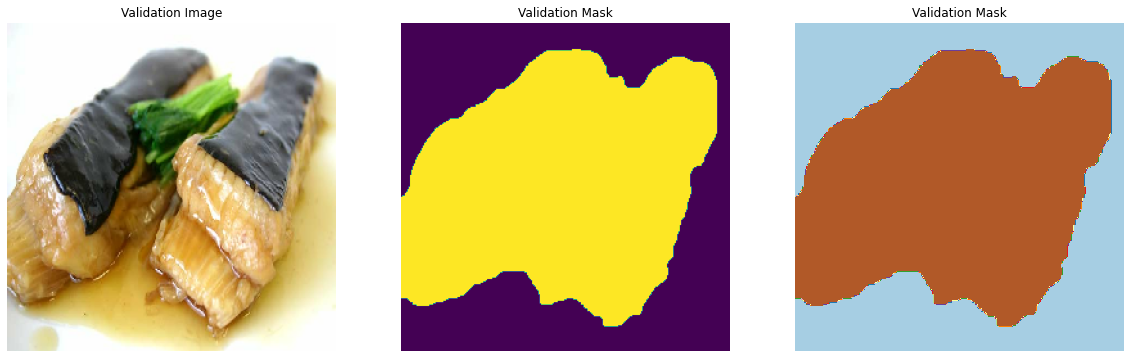

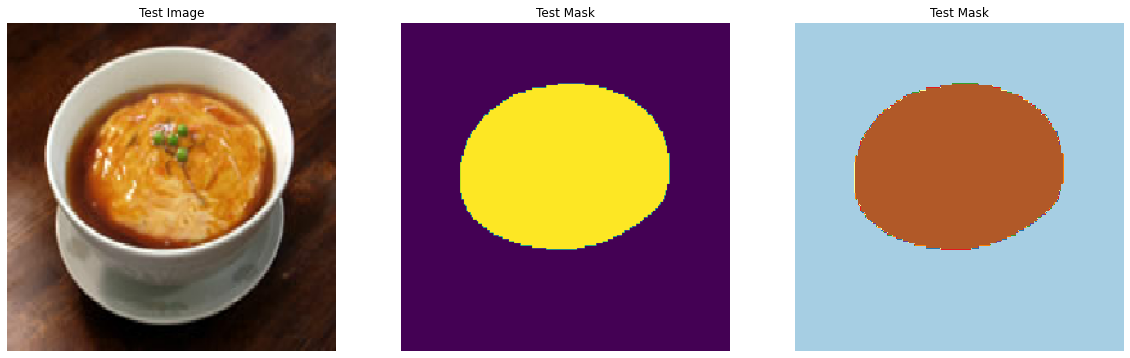

In [17]:
for tn_images, tn_masks in train_dataset.take(3).cache().repeat():
    break
for vl_images, vl_masks in validation_dataset.take(3).cache().repeat():
    break
for tst_images, tst_masks in test_dataset.take(3).cache().repeat():
    break

for i in range(3):
    N = random.randint(0, BATCH_SIZE-1)
    
    images = [tn_images[N], vl_images[N], tst_images[N]]
    masks = [tn_masks[N], vl_masks[N], tst_masks[N]]
    title = ['Train Image', 'Validation Image', 'Test Image', 'Train Mask', 'Validation Mask', 'Test Mask']

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(images[i])
    arr[0].set_title(title[i])
    arr[0].axis("off")
    arr[1].imshow(masks[i])
    arr[1].set_title(title[i+3])
    arr[1].axis("off")
    arr[2].imshow(masks[i], cmap='Paired')
    arr[2].set_title(title[i+3])
    arr[2].axis("off")

# Visualization callback

In [19]:
# Visualization callback to see how mask prediction progresses.
class MaskCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        plot_mask_predictions(validation_dataset,BATCH_SIZE)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [29]:
# pixel accuracy callback
class PixelAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pixel_accuracy(val_dataset,1)

def pixel_accuracy(dataset):
    total = 0
    correct = 0
    for image, mask in dataset:
        pred_mask = create_mask(model.predict(image))
        total += IMAGE_SIZE * IMAGE_SIZE
        pred = np.squeeze(pred_mask)
        gt = np.squeeze(mask)
        im = np.squeeze(image)
        correct += np.sum(mask == mask)
        print("gt", np.unique(gt,return_counts=True))
        print("pred" , np.unique(pred,return_counts=True))
    print("Pixel Accuracy: ", correct/total)

In [13]:
def plot_mask_predictions(dataset, examples=1):
    plt.figure(figsize=(21, 7 * examples))

    for i, (image, mask) in enumerate(dataset.take(examples)):
        ax = plt.subplot(examples, 3, 3*i+1)
        plt.imshow(image[0])
        plt.axis("off")

        ax = plt.subplot(examples, 3, 3*i+2)
        print(np.unique(mask[0].numpy().astype("uint8").squeeze(axis=2)))
        plt.imshow(mask[0].numpy().astype("uint8").squeeze(axis=2), cmap='gray', vmin=0, vmax=tf.math.reduce_max(mask[0]))
        plt.axis("off")


        pred_mask = create_mask(model.predict(image))

        ax = plt.subplot(examples, 3, 3*i+3)
        plt.imshow(pred_mask.numpy().astype("uint8").squeeze(axis=2), cmap='gray', vmin=0, vmax=tf.math.reduce_max(pred_mask))
        plt.axis("off")

    plt.show()

# Model

In [13]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
        )(block_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [14]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [15]:
def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    model = tf.keras.Model(inputs=model_input, outputs=model_output)
    
    return model

In [16]:
model = DeeplabV3(image_size=IMAGE_SIZE, num_classes=CLASSES)
model.summary()
CLASSES

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

103

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

## Model Training

In [30]:
EPOCHS = 30

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="cp.h5", 
    verbose=1, 
    save_weights_only=False , monitor='val_loss', save_best_only=True)

early_callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

In [26]:
with tf.device("GPU"):
    history = model.fit(train_dataset, 
                        validation_data = validation_dataset, 
                        epochs = EPOCHS, 
                        verbose=1, 
                        callbacks=[cp_callback, early_callback],
                        batch_size = BATCH_SIZE, 
                        shuffle = True)

Epoch 1/30
197/197 [==============================] - 116s 591ms/step - loss: 0.7378 - accuracy: 0.8048 - val_loss: 3.4638 - val_accuracy: 0.5430

Epoch 00001: val_loss did not improve from 2.58101
Epoch 2/30
197/197 [==============================] - 117s 592ms/step - loss: 0.6964 - accuracy: 0.8168 - val_loss: 3.3194 - val_accuracy: 0.5521

Epoch 00002: val_loss did not improve from 2.58101
Epoch 3/30
197/197 [==============================] - 117s 592ms/step - loss: 0.6322 - accuracy: 0.8326 - val_loss: 3.4444 - val_accuracy: 0.5446

Epoch 00003: val_loss did not improve from 2.58101
Epoch 4/30
197/197 [==============================] - 117s 592ms/step - loss: 0.5701 - accuracy: 0.8493 - val_loss: 3.3263 - val_accuracy: 0.5508

Epoch 00004: val_loss did not improve from 2.58101
Epoch 5/30
197/197 [==============================] - 117s 592ms/step - loss: 0.4828 - accuracy: 0.8736 - val_loss: 3.5402 - val_accuracy: 0.5473

Epoch 00005: val_loss did not improve from 2.58101
Epoch 6/30

In [ ]:
model.save('model.h5')

# Model Evaluation

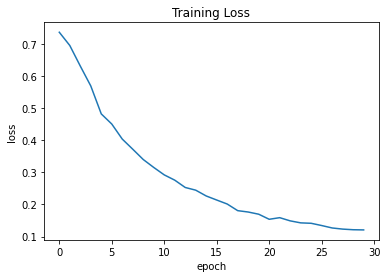

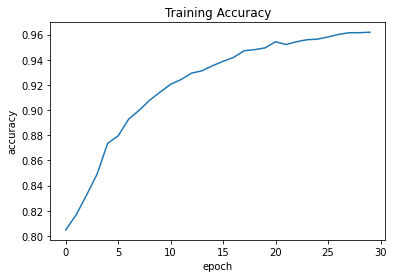

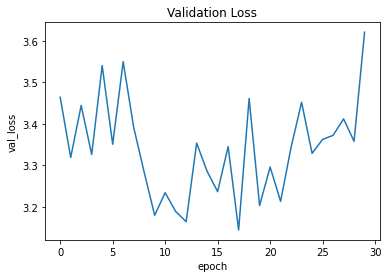

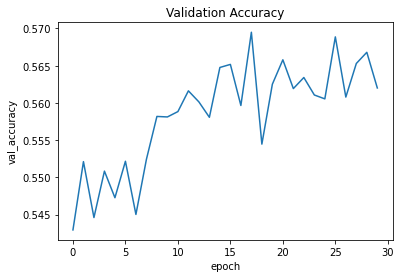

In [32]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [12]:
model = load_model('/kaggle/working/model.h5')

In [13]:
# train_loss, train_accuracy = model.evaluate(train_dataset, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(validation_dataset, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_dataset, batch_size = 32)

32/32 [==============================] - 13s 287ms/step - loss: 2.0116 - accuracy: 0.6724


In [15]:
# print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Validation Dataset: 56.2%
Model Accuracy on the Test Dataset: 67.24%


### Intersection-over-Union (IoU)

In [16]:
def iou_score(dataset):
    intersections, unions, max_ious, min_ious = [], [], [], []
    
    for images, masks in dataset:
        pred_mask = model.predict(images)
        intersection = np.logical_and(masks, pred_mask)
        union = np.logical_or(masks, pred_mask)
        intersection_sum = np.array([np.sum(inter) for inter in intersection])
        union_sum = np.array([np.sum(un) for un in union])
        batch_iou_score = intersection_sum / union_sum
        batch_min_iou = np.amin(batch_iou_score)
        batch_max_iou = np.amax(batch_iou_score)
        
        intersections.append(np.sum(intersection))
        unions.append(np.sum(union))
        min_ious.append(batch_min_iou)
        max_ious.append(batch_max_iou)

    min_iou = np.amin(min_ious)
    max_iou = np.amax(max_ious)
    mean_iou = np.sum(intersections) / np.sum(unions)   
    
    return min_iou, max_iou, mean_iou

In [17]:
# train_min_iou, train_max_iou, train_mean_iou = iou_score(train_dataset)
validation_min_iou, validation_max_iou, validation_mean_iou = iou_score(validation_dataset)
test_min_iou, test_max_iou, test_mean_iou = iou_score(test_dataset)

In [18]:
# print(f'IoU on the Training Dataset: \n Minimum IoU Score: {round(train_min_iou*100, 2)}% \n Maximum IoU Score: {round(train_max_iou*100, 2)}% \n Mean IoU Score: {round(train_mean_iou*100, 2)}% \n')
print(f'IoU on the Validation Dataset: \n Minimum IoU Score: {round(validation_min_iou*100, 2)}% \n Maximum IoU Score: {round(validation_max_iou*100, 2)}% \n Mean Iou Score: {round(validation_mean_iou*100, 2)}% \n')
print(f'IoU on the Test Dataset: \n Minimum IoU Score: {round(test_min_iou*100, 2)}% \n Maximum IoU Score: {round(test_max_iou*100, 2)}% \n Mean IoU Score: {round(test_mean_iou*100, 2)}% \n')

IoU on the Validation Dataset: 
 Minimum IoU Score: 4.99% 
 Maximum IoU Score: 100.0% 
 Mean Iou Score: 45.88% 

IoU on the Test Dataset: 
 Minimum IoU Score: 6.0% 
 Maximum IoU Score: 100.0% 
 Mean IoU Score: 44.2% 



## Predict image segmentations using the trained Model

In [21]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [20]:
def show_predictions(dataset, num):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

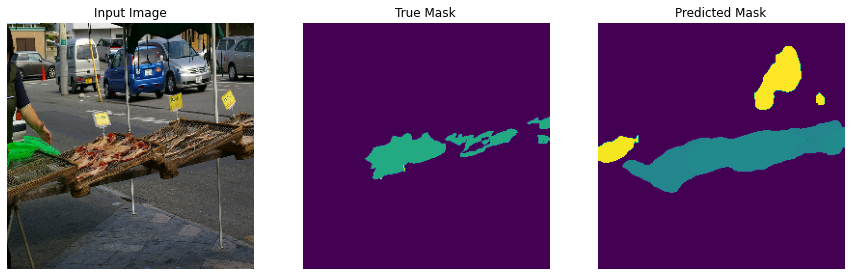

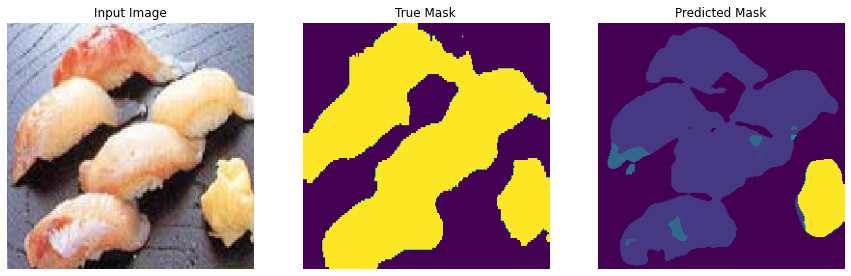

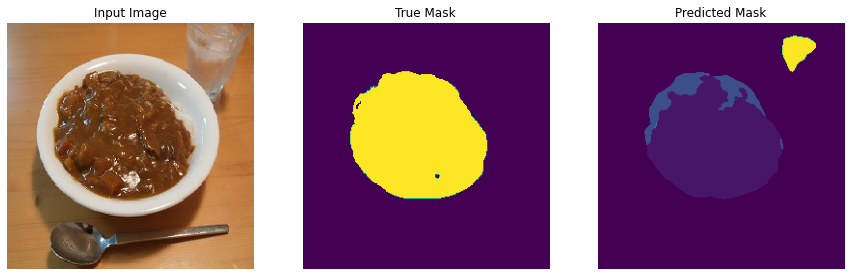

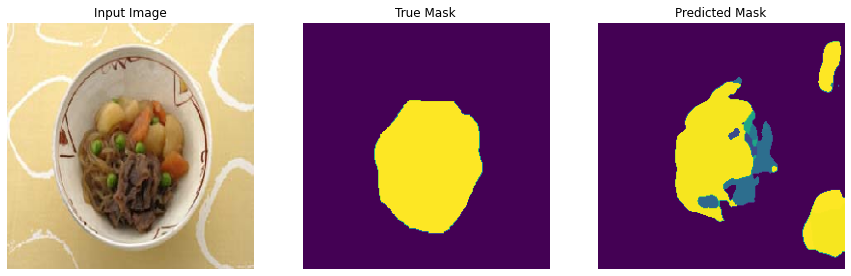

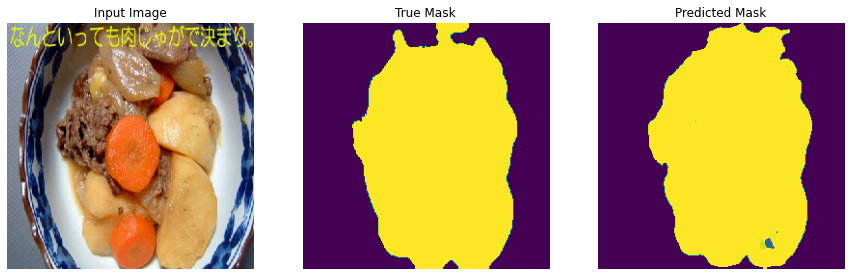

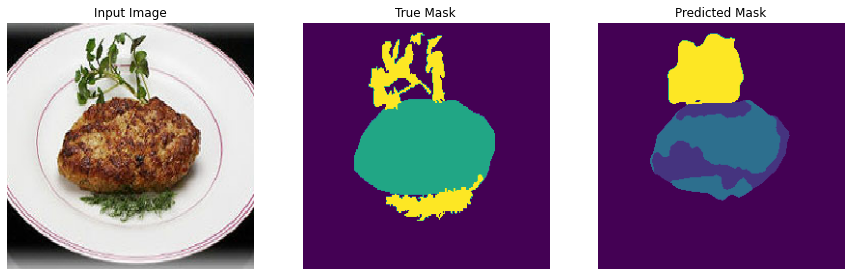

In [22]:
show_predictions(validation_dataset, 6)

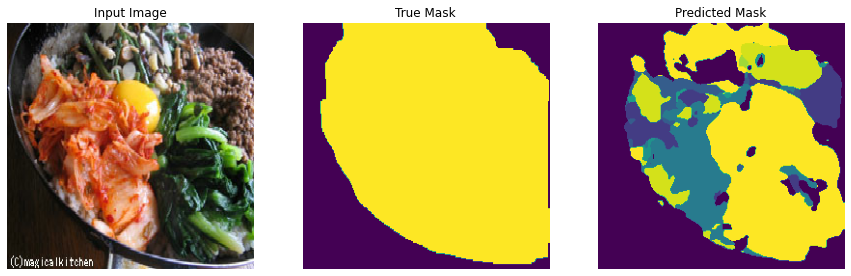

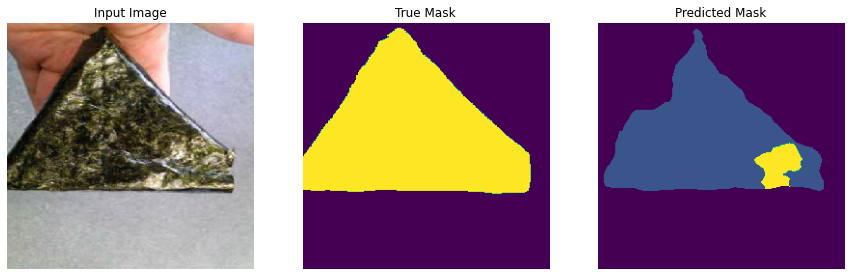

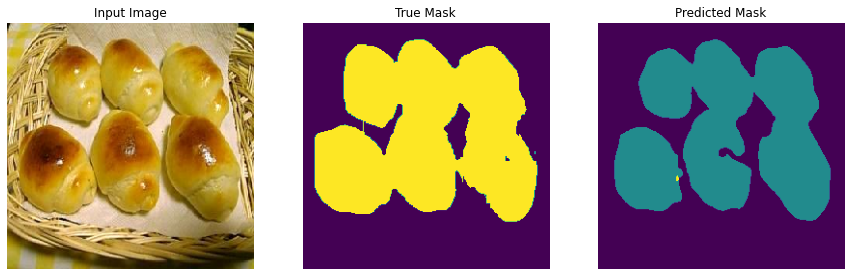

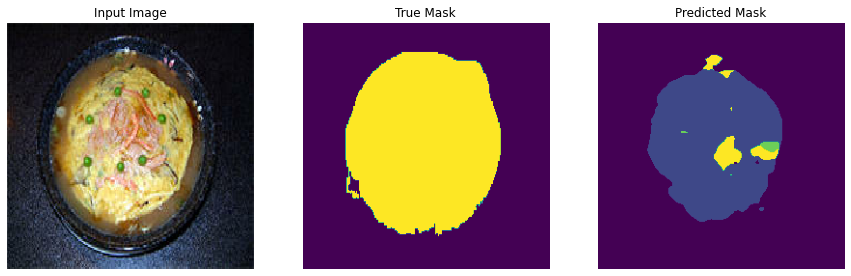

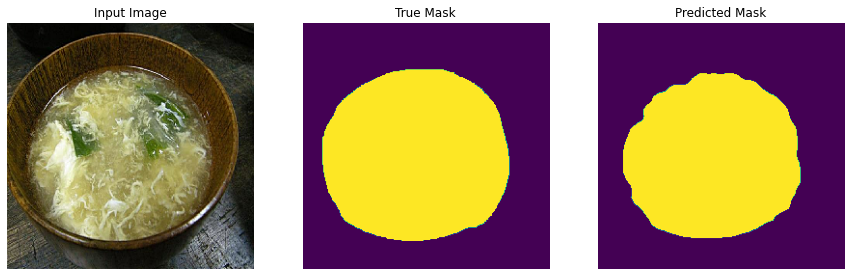

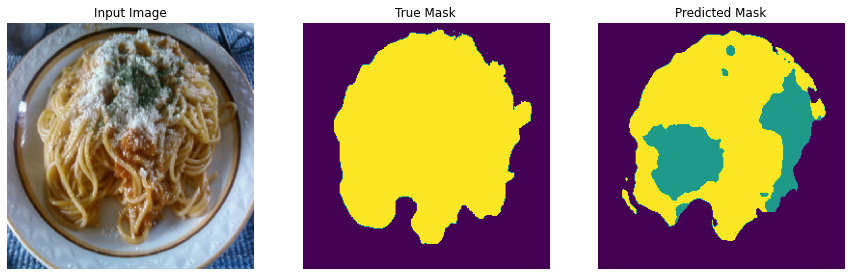

In [23]:
show_predictions(test_dataset, 6)

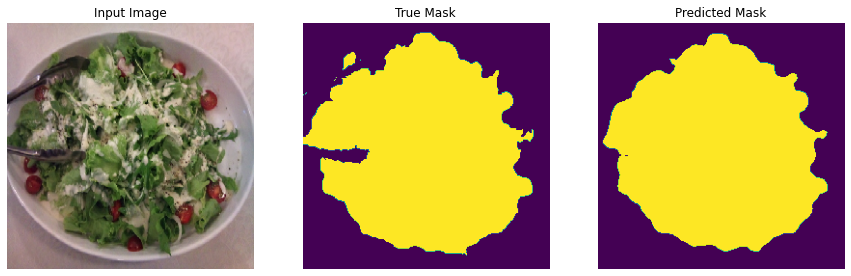

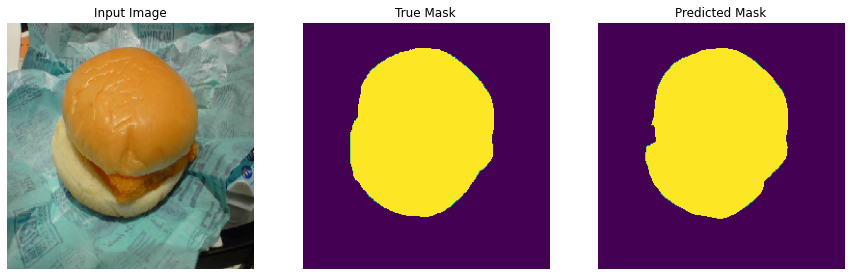

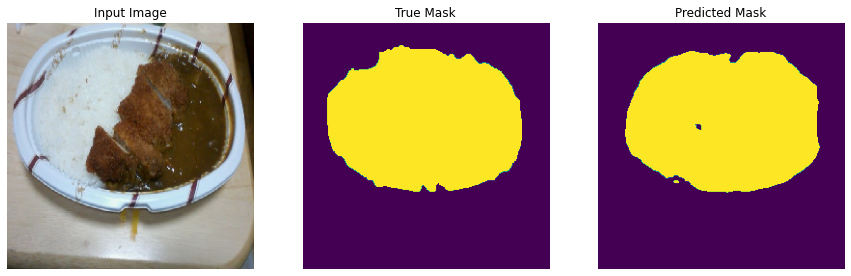

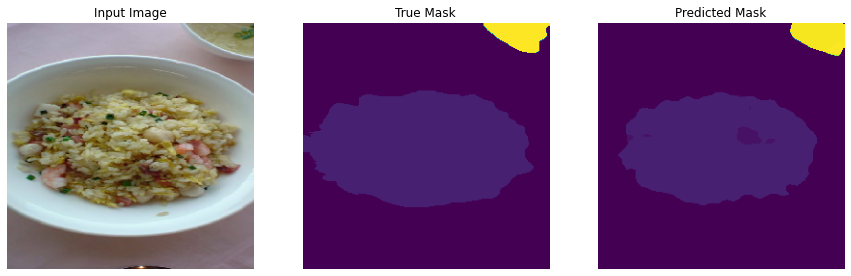

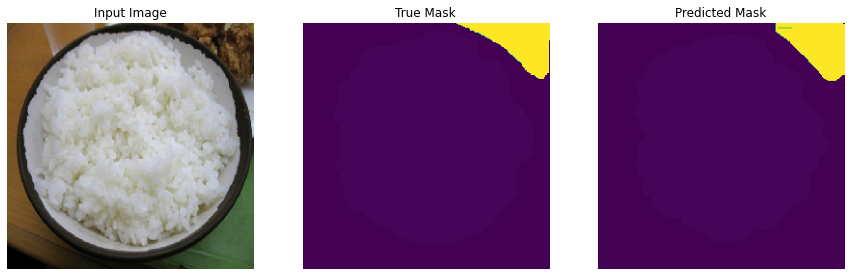

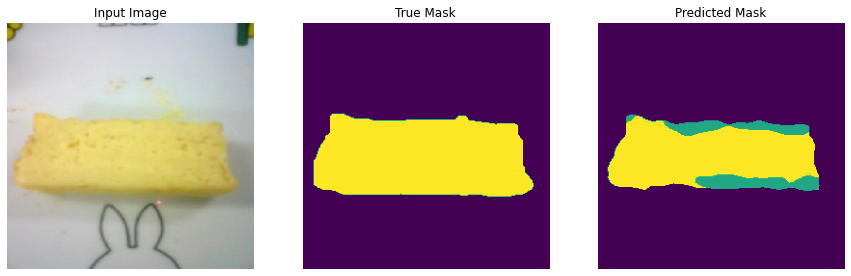

In [24]:
show_predictions(train_dataset, 6)

In [15]:
# Define a function to read the category file and return a dictionary mapping IDs to names
def read_category_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    category_dict = {}
    for line in lines[1:]:
        category_id, category_name = line.strip().split('\t')
        category_dict[int(category_id)] = category_name
    return category_dict